In [1]:
#importing all the necessary libraries.
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#importing the initial data from the file "Mallards_initial data.xlsx"
mallards=pd.read_excel("Mallards_initial data.xlsx")
#The line bellow is used for debugging.
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
# instead of any other type of grouping we choose to group the mallards by ordering them by population.
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
#Saving the ordered by population data into the Excel file "mallards_ordered.xlsx"
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
#Creating the dataframe that is going to be used as y. Each column will be used as y in a different model.
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

#Generating the labels by making the next coordinates as the destination coordinates for the previous row.
for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [8]:
# drop last two rows from ordered dataframe. It is used for data management.
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe. It is used for data management.
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [9]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [10]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [11]:
# Making different splits for different models, one for longitude and one latitude.
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [12]:
X_train.shape

(15929, 6)

In [13]:
# We use standard scaler to do our scalling, instead of manual scaling.
scaler = StandardScaler()

In [14]:
# Making sure that date and hour have the necessary format.
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [15]:
# Making sure that date and hour have the necessary format.
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [16]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

# drop the original datetime columns
X_train_scaled_df = X_train_scaled_df.drop(['date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['date'], axis=1)

In [17]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
11284,0.030042,-0.524242,0.125260,0.133639,21,5
11964,0.138355,-0.524242,0.127363,0.126657,19,0
5390,-0.879784,-0.524242,0.125449,0.134608,15,4
860,-1.356359,-0.524242,0.124414,0.135708,18,2
15795,0.939869,-0.524242,0.125983,0.133088,3,0


In [18]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
16564,1.113169,1.907515,0.123946,0.131636,21,4
19327,1.849695,1.907515,-4.781471,-1.732344,10,0
15022,0.874881,-0.524242,0.126517,0.128668,0,3
2457,-1.139734,-0.524242,0.124135,0.135700,5,1
9210,-0.229908,-0.524242,0.121909,0.135181,17,5


In [19]:
#Important part of the code. it is the place where we set our configuration.
n_units = 32
activation = 'tanh'
loss_function = 'mean_squared_error'

In [20]:
# A separate model to detect latitude.
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [21]:
# A separate model to detect longitude.
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [22]:
print(X_train_scaled_df.values.shape)

(15929, 6)


In [23]:
print(y_lat_train.values.shape)

(15929,)


In [24]:
print(modelLat.input_shape)

(None, 6)


In [25]:
X_train_scaled_df.shape

(15929, 6)

In [26]:
X_test_scaled_df.shape

(3983, 6)

In [27]:
# Fitting the data in the model for latitude.
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 3ms/step - loss: 2186.3259 - val_loss: 1424.0162
Epoch 2/1000
498/498 [==============================] - 2s 3ms/step - loss: 958.8004 - val_loss: 589.5820
Epoch 3/1000
498/498 [==============================] - 1s 3ms/step - loss: 367.9437 - val_loss: 200.9539
Epoch 4/1000
498/498 [==============================] - 1s 3ms/step - loss: 112.7491 - val_loss: 51.8287
Epoch 5/1000
498/498 [==============================] - 1s 3ms/step - loss: 25.5833 - val_loss: 9.6656
Epoch 6/1000
498/498 [==============================] - 2s 3ms/step - loss: 4.4381 - val_loss: 1.8130
Epoch 7/1000
498/498 [==============================] - 1s 3ms/step - loss: 1.1044 - val_loss: 0.8430
Epoch 8/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.6852 - val_loss: 0.6463ETA: 0s - loss: 0.69
Epoch 9/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.5422 - val_loss: 0.5177
Epoch 10/1000
498/498 [=====================

498/498 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 79/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 80/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 9.3526e-04A: 0s - 
Epoch 81/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 82/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 83/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 9.8703e-04A: 0s - loss: 0
Epoch 84/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 9.0479e-04
Epoch 85/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 86/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 87/1000
498/498 [=============================

498/498 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 9.3477e-04
Epoch 154/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 8.0869e-04
Epoch 155/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.9066e-04
Epoch 156/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0016 - ETA: 0s - loss: 0.0
Epoch 157/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 158/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 8.0411e-04
Epoch 159/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 8.7422e-04
Epoch 160/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 8.3185e-04
Epoch 161/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 162/1000
498/498 [=========

498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 229/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010A: 0s - loss:
Epoch 230/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 7.5516e-04A: 0s - loss: 0.00
Epoch 231/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.2673e-04
Epoch 232/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 233/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0012.1499e-0 - ETA: 0s - loss:
Epoch 234/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 235/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 8.0972e-04
Epoch 236/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 8.7203e-04
Epoch 

498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.4784e-04
Epoch 302/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 303/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.7941e-04ETA: 0s 
Epoch 304/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 7.9233e-04
Epoch 305/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.9103e-04
Epoch 306/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.7983e-04
Epoch 307/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 8.0673e-04
Epoch 308/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.7360e-04
Epoch 309/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.6849e-048e- - ETA: 0s - loss: 9.4 - ETA: 0s - lo

498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.8062e-04 - ETA: 0s
Epoch 376/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 8.1955e-04
Epoch 377/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.5543e-04
Epoch 378/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 8.2159e-04
Epoch 379/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 8.0740e-04
Epoch 380/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.5083e-04
Epoch 381/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 8.2975e-04
Epoch 382/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 9.2910e-04
Epoch 383/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.4853e-04
Epoch 384/1000
498/498 [=========

498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.4408e-04
Epoch 449/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 450/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 8.2152e-04
Epoch 451/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.4587e-043
Epoch 452/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 453/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.9095e-04
Epoch 454/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.4471e-04
Epoch 455/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 8.6130e-04
Epoch 456/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.8945e-04
Epoch 457/1000
498/498 [==========================

498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 525/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 8.4268e-040    - ETA: 0s - loss: 0.00
Epoch 526/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 7.3582e-04
Epoch 527/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.2907e-04
Epoch 528/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 8.2728e-04
Epoch 529/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 9.8790e-04
Epoch 530/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4745e-04
Epoch 531/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.6601e-04
Epoch 532/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.6966e-04
Epoch 533/1000
498/4

498/498 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 7.6935e-04
Epoch 601/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 9.0483e-04
Epoch 602/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.5176e-04
Epoch 603/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4202e-04
Epoch 604/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 7.8862e-04
Epoch 605/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 7.8635e-04
Epoch 606/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.5258e-04
Epoch 607/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.6006e-04
Epoch 608/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.3765e-04
Epoch 609/1000
498/498 [===================

Epoch 676/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6448e-04
Epoch 677/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4005e-046e - ETA: 0s - loss:
Epoch 678/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.1131e-04
Epoch 679/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.2776e-04
Epoch 680/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.8652e-04
Epoch 681/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4565e-04
Epoch 682/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.5007e-04- ETA: 0s - loss: 9.2067e-
Epoch 683/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.5070e-04
Epoch 684/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val

498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6258e-04
Epoch 752/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4267e-04
Epoch 753/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4953e-04
Epoch 754/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.8031e-04
Epoch 755/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.2662e-04
Epoch 756/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 7.8261e-04
Epoch 757/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 7.3873e-04
Epoch 758/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6123e-04
Epoch 759/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.3595e-04
Epoch 760/1000
498/498 [===================

498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4663e-04
Epoch 828/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.8119e-04
Epoch 829/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 9.9973e-049e-
Epoch 830/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.9525e-04
Epoch 831/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.1136e-04
Epoch 832/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4357e-04
Epoch 833/1000
498/498 [==============================] - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 9. - 1s 2ms/step - loss: 0.0010 - val_loss: 8.4861e-04
Epoch 834/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.1128e-04
Epoch 835/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.

498/498 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 8.0694e-04
Epoch 903/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6999e-04
Epoch 904/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6079e-04
Epoch 905/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.3694e-04
Epoch 906/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6979e-04
Epoch 907/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6549e-04
Epoch 908/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 8.3430e-04
Epoch 909/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4633e-04
Epoch 910/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 911/1000
498/498 [=======================

498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.3193e-04
Epoch 978/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 7.6652e-04
Epoch 979/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.5854e-04
Epoch 980/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 7.4567e-04
Epoch 981/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 7.5905e-040 
Epoch 982/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.3526e-04
Epoch 983/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.4820e-04
Epoch 984/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.3377e-04
Epoch 985/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 7.6209e-04
Epoch 986/1000
498/498 [=================

In [28]:
# Fitting the data in the model for latitude.
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 3ms/step - loss: 44.3415 - val_loss: 2.9488
Epoch 2/1000
498/498 [==============================] - 1s 2ms/step - loss: 1.8336 - val_loss: 1.3332
Epoch 3/1000
498/498 [==============================] - 1s 2ms/step - loss: 1.0222 - val_loss: 0.8257
Epoch 4/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.6534 - val_loss: 0.5487
Epoch 5/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.4445 - val_loss: 0.3830
Epoch 6/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.3148 - val_loss: 0.2753
Epoch 7/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.2293 - val_loss: 0.2025
Epoch 8/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.1701 - val_loss: 0.1510
Epoch 9/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.1283 - val_loss: 0.1145
Epoch 10/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.09

498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 81/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 82/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 83/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019- ETA: 0s - loss
Epoch 84/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 85/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 86/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 87/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 88/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 89/1000
498/498 [==============================] - 1s 2ms/step - 

Epoch 159/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 160/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 161/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 162/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 163/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 164/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 165/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019: 0s - loss: 0.00
Epoch 166/1000
498/498 [==============================] - ETA: 0s - loss: 0.004 - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 167/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 168/1000
498/498 

498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 236/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 237/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0019 0s - loss: 0
Epoch 238/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 239/1000
498/498 [==============================] - 3s 6ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 240/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 241/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 242/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 243/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 244/1000
498/498 [==============================] - 1s 2ms/s

498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 314/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 315/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 316/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 317/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 318/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 319/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 320/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 321/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 322/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 392/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019.004 - ETA: 0s -
Epoch 393/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 394/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 395/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 396/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 397/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021.0024   - ETA: 0s - lo
Epoch 398/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 399/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 400/1000
498/498 [=================

498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 470/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 471/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 472/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 473/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 474/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019: 0s - los
Epoch 475/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 476/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 477/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 478/1000
498/498 [==============================] - 1s 3ms/step

498/498 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 547/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 548/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 549/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 550/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 551/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 552/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 553/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 554/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 555/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - ETA: 0s - loss: 0.003 - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 625/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 626/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 627/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020 ETA: 0s - loss
Epoch 628/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 629/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 630/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 631/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 632/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 633/1000
498/498 [================

498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 703/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 704/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 705/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 706/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 707/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 708/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 709/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 710/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 711/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 781/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 782/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 783/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 784/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 785/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020 0s - loss: 0
Epoch 786/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 787/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 788/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 789/1000
498/498 [==============================] - 1s 2ms/s

498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 859/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 860/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 861/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 862/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 863/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 864/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 865/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 866/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 867/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 936/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 937/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021 ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003
Epoch 938/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 939/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 940/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 941/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 942/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 943/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 944/1000
498/498 [=========

In [29]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.02609990289320432
Root Mean Squared Error (RMSE): 0.05000925942067358


In [30]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.013418703414070341
Root Mean Squared Error (RMSE): 0.02927445943917765


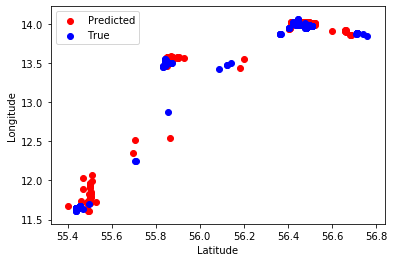

In [31]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='True')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [32]:
X_test["population"].shape

(3983,)

In [33]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [34]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [35]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [36]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [37]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [38]:
# Create a dataframe with all the values, (predicted and actual), in order to be used for diagrams and comparisons.
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [39]:
combined_df = combined_df.dropna()

In [40]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.445541,14.015425,56.439716,13.991791
3,88.0,56.455070,14.017038,56.441143,13.988527
6,131.0,56.448296,14.016026,56.439716,13.992242
17,27.0,56.452789,14.017082,56.439903,13.992476
19,23.0,56.449524,14.016118,56.439484,13.992446
31,67.0,56.454216,14.016430,56.439350,13.992638
34,24.0,56.454086,14.015374,56.440166,13.992716
35,131.0,56.448586,14.016276,56.439930,13.992993
41,152.0,56.446014,14.001844,56.440140,13.992735
42,152.0,56.453773,13.999369,56.440044,13.992678


In [41]:
#selecting the most frequent population of the populations that have more than 20 members.
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [42]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.446014,14.001844,56.440140,13.992735
42,152.0,56.453773,13.999369,56.440044,13.992678
181,152.0,56.446075,14.002649,56.440220,13.992155
218,152.0,56.446098,14.000812,56.440342,13.992517
257,152.0,56.181824,13.429825,56.439884,13.991575
449,152.0,56.431725,14.009126,56.439644,13.992051
466,152.0,56.452232,13.999126,56.439968,13.992618
836,152.0,56.441231,14.004676,56.439949,13.992587
1010,152.0,56.444893,14.004876,56.439953,13.993013
1063,152.0,56.453049,13.996235,56.439720,13.992579


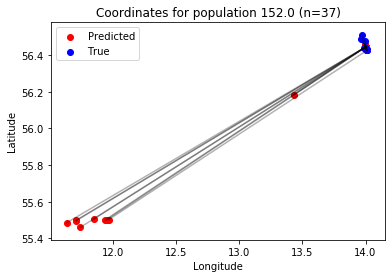

In [43]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [44]:
most_frequent_pop_df.shape

(37, 5)

In [45]:
# Removing outliers
filtered_df = filtered_df[(filtered_df['Pred_longitude'] >= 13.7) & (filtered_df['longitude'] >= 13.7)]

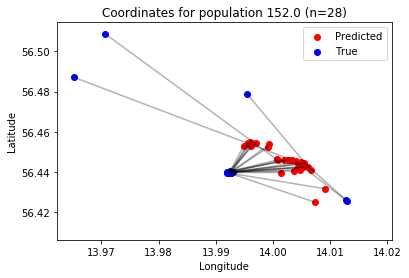

In [46]:
# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()

In [47]:
# Removing outliers
combined_df = combined_df[(combined_df['Pred_longitude'] >= 13.7) & (combined_df['longitude'] >= 13.7)]

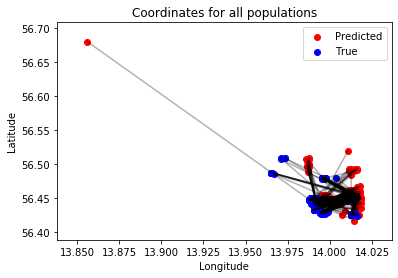

In [48]:
# Create scatter plot of predicted and true coordinates
plt.scatter(combined_df['Pred_longitude'], combined_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in combined_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for all populations")

# Show plot
plt.show()